## Problem Statement

Sales Forecasting
The task involves predicting the quantity of Coca-Cola each customer will purchase in the next month.

The following code was created by another department and the stakeholders have raised a few concerns regarding the model's accuracy and the clarity of the existing code, as well as potential improvements for future models.

These concerns are as follows:

The stakeholders have found that the model has a higher error rate than they anticipated. They formed this impression based on the analysis presented to them (refer to the graph in the notebook).
The stakeholders could not understand the purpose of each line of code or how to correct it.
The stakeholders believe there might be additional information that could enhance sales predictions, and they would like a concise summary of how to improve the model going forward.
The stakeholders need a sales forecast for January 2023 using the current model. Note that you must create the appropriate test set with features that the current model needs, assuming the same weather conditions as January 2022 and the last record of coolers per customer.
Your objective is to address these concerns and build another model that the stakeholders can rely on. To accomplish this, you are required to review and understand the code provided. Note that the provided dataset is entirely synthetically generated.

Upon completion of the challenge, submit the finalized Notebook along with a submissions.csv file containing your predictions for January 2023. Please prepare a short presentation to discuss the model's logic at a high level along with any assumptions, changes, and improvements you may suggest.

In [374]:
# Column descriptions:
## Calmonth: month of 2022 in yyyyMM format
## uni_box: sale of calmonth in volume of product (similar to liters)
## month_1: sale of previous month (uni_box sold of last month)
## month_2: sale of 2 months ago (uni_box sold 2 months ago)
## month_3: sale of 3 months ago (uni_box sold 3 months ago)
## Cliente: customer id
## num_coolers: Number of coolers that are in the store
## num_doors: Sum of doors that the assigned coolers have
## highest_temp: max temp recorded
## lowest_temp: lowest temp recorded
## avg_temp: average temp recorded

In [1]:
!pip install ipykernel


## Importing necessary libraries

**Let's start by importing libraries we need.**

In [3]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np   
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor,RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, StackingRegressor
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV

In [3]:

!pip install scikit-learn


ERROR: Could not find a version that satisfies the requirement ipykernal (from versions: none)
ERROR: No matching distribution found for ipykernal


   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
    --------------------------------------- 0.3/11.0 MB ? eta -:--:--
   ------- -------------------------------- 2.1/11.0 MB 7.3 MB/s eta 0:00:02
   ------------ --------------------------- 3.4/11.0 MB 7.2 MB/s eta 0:00:02
   ----------------- ---------------------- 4.7/11.0 MB 6.8 MB/s eta 0:00:01
   ------------------------ --------------- 6.8/11.0 MB 7.9 MB/s eta 0:00:01
   ------------------------------ --------- 8.4/11.0 MB 7.9 MB/s eta 0:00:01
   ---------------------------------------- 11.0/11.0 MB 8.5 MB/s eta 0:00:00


## Reading the dataset

In [4]:
# Loading the sales dataset from a CSV file into a DataFrame
sales = pd.read_csv('sales.csv')

# Loading the coolers dataset from a CSV file into a DataFrame
coolers = pd.read_csv('coolers.csv')

# Loading the weather dataset from a CSV file into a DataFrame
weather = pd.read_csv('weather.csv')

## Overview of the dataset

In [5]:
# Merging the sales DataFrame with the coolers DataFrame
# This combines the number of coolers per customer with sales data based on 'Cliente' and 'calmonth'
# Any missing values will be filled with 0
sales_coolers = sales.merge(coolers, on=["Cliente", "calmonth"], how='left').fillna(0)

# Merging the resulting DataFrame (sales_coolers) with the weather DataFrame
# This adds weather conditions to the existing dataset based on 'Cliente' and 'calmonth'
# Again, any missing values will be filled with 0
sales_coolers_weather = sales_coolers.merge(weather, on=["Cliente", "calmonth"], how='left').fillna(0)

# Extracting the month from 'calmonth' and converting it to an integer
# This creates a new column 'month' that contains only the month part of 'calmonth'
sales_coolers_weather['month'] = sales_coolers_weather['calmonth'].astype(str).str[-2:].astype(int)

In [6]:
# Creating a copy of the sales_coolers_weather DataFrame to avoid modifying the original data
data = sales_coolers_weather.copy()

# Dropping the 'calmonth' column from the DataFrame as it is no longer needed
# This helps to reduce redundancy and streamline the dataset
data.drop('calmonth', axis=1, inplace=True)

# Setting a multi-index on the DataFrame using 'Cliente' and 'month'
# This allows for more efficient data manipulation and retrieval based on these two keys
data.set_index(['Cliente', 'month'], inplace=True)

### View the first 5 rows of the dataset

In [7]:
data.head()

uni_box  month_1  month_2  month_3  num_coolers  num_doors  \
Cliente   month                                                               
500155249 12        2.32     3.06     2.54     3.80          2.0        3.0   
          11        3.06     2.54     3.80     2.54          2.0        3.0   
          10        2.54     3.80     2.54     4.86          2.0        3.0   
          9         3.80     2.54     4.86     5.92          2.0        3.0   
          8         2.54     4.86     5.92     6.34          2.0        3.0   

                 highest_temp  lowest_temp  avg_temp  
Cliente   month                                       
500155249 12             88.0         25.0      60.0  
          11             90.0         43.0      63.0  
          10             93.0         50.0      71.0  
          9              91.0         63.0      78.0  
          8             104.0         72.0      84.0

### Check data types and number of non-null values for each column

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 318672 entries, (500155249, 12) to (510847907, 1)
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   uni_box       318672 non-null  float64
 1   month_1       318672 non-null  float64
 2   month_2       318672 non-null  float64
 3   month_3       318672 non-null  float64
 4   num_coolers   318672 non-null  float64
 5   num_doors     318672 non-null  float64
 6   highest_temp  318672 non-null  float64
 7   lowest_temp   318672 non-null  float64
 8   avg_temp      318672 non-null  float64
dtypes: float64(9)
memory usage: 24.0 MB


- We can see that there are total of 8 columns and 318,672 rows in the dataset.
- The number of non-null values of each column is equal to the number of total rows in the dataset i.e. no null value. We can further confirm this using `isna()` method.

In [9]:
data.isna().sum()

uni_box         0
month_1         0
month_2         0
month_3         0
num_coolers     0
num_doors       0
highest_temp    0
lowest_temp     0
avg_temp        0
dtype: int64

- There are no missing values in the data.

### Summary of the dataset

In [10]:
# Summary of continuous columns
data.describe().T

,count,mean,std,min,25%,50%,75%,max
uni_box,318672.0,6.807413,13.587793,0.0,0.0,3.38,8.79,1588.37
month_1,318672.0,6.833362,13.094352,0.0,0.0,3.59,8.88,1495.69
month_2,318672.0,6.799955,12.808298,0.0,0.0,3.38,8.88,1251.69
month_3,318672.0,6.794255,12.799700,0.0,0.0,3.59,8.88,1251.69
num_coolers,318672.0,1.317662,1.198965,0.0,1.0,1.00,2.00,20.00
num_doors,318672.0,1.968563,1.904616,0.0,1.0,1.00,3.00,39.00
highest_temp,318672.0,96.022923,15.759638,0.0,91.0,97.00,104.00,111.00
lowest_temp,318672.0,48.896910,17.850629,0.0,34.0,50.00,68.00,75.00
avg_temp,318672.0,70.091985,14.914364,0.0,60.0,71.00,83.00,90.00


### Insights Across Features
- 
uni_bo
x
The mean for uni_box is 6.8, while the median is 3.3. This indicates that the distribution of uni_box is right-skewed, with a heavy tail on the right. This suggests that a small number of observations have a significantly higher count of units, pulling the mean up
- .
month_1, month_2, month_3
The means for month_1, month_2, and month_3 are approximately 6.83, 6.80, and 6.79 respectively, with medians slightly lower than their means. This consistency across months suggests stable sales performance over time, but the slight drop in mean from month 1 to month 3 could indicate a seasonal decline or changing customer preferenc
- es.
num_coolers
The mean number of coolers is 1.32 with a median of 1.00. The mean being higher than the median indicates a right-skewed distribution, suggesting that while most customers have one cooler, there are some outliers with many more coo
- lers.
num_doors
The average number of doors is 1.97 with a median of 1.00. Similar to num_coolers, this indicates a right-skewed distribution where most observations have only one door, but a few locations have a significantly higher 
- number.
highest_temp
The mean highest temperature is around 96°F with a median of 97°F. The closeness of these values suggests that the temperature distribution may be relatively symmetric; however, the standard deviation of 15.76 indicates variability that could impact product per
- formance.
lowest_temp
The average lowest temperature is about 48.90°F with a median of 50°F. Again, the proximity of mean and median suggests a fairly symmetric distribution, but the minimum value of 0°F indicates potential outlier conditions that could affect sales or product
-  viability.
avg_temp
The mean average temperature is approximately 70°F with a median of 71°F. This slight difference suggests symmetry in temperature readings, indicating consistent environmental conditions that may influence customer behavior and product demand.

### Number of unique values in each column

In [11]:
data.nunique()

uni_box         4733
month_1         4711
month_2         4659
month_3         4648
num_coolers       17
num_doors         21
highest_temp      26
lowest_temp       41
avg_temp          33
dtype: int64

In [12]:
# taking a copy 
df = data.copy()

## <a name='link2'>Exploratory Data Analysis (EDA) Summary</a>

**The below functions need to be defined to carry out the EDA.**

In [13]:
def histogram_boxplot(data, feature, figsize=(15, 10), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (15,10))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a triangle will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

In [399]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 2, 6))
    else:
        plt.figure(figsize=(n + 2, 6))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n],
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

### Univariate analysis

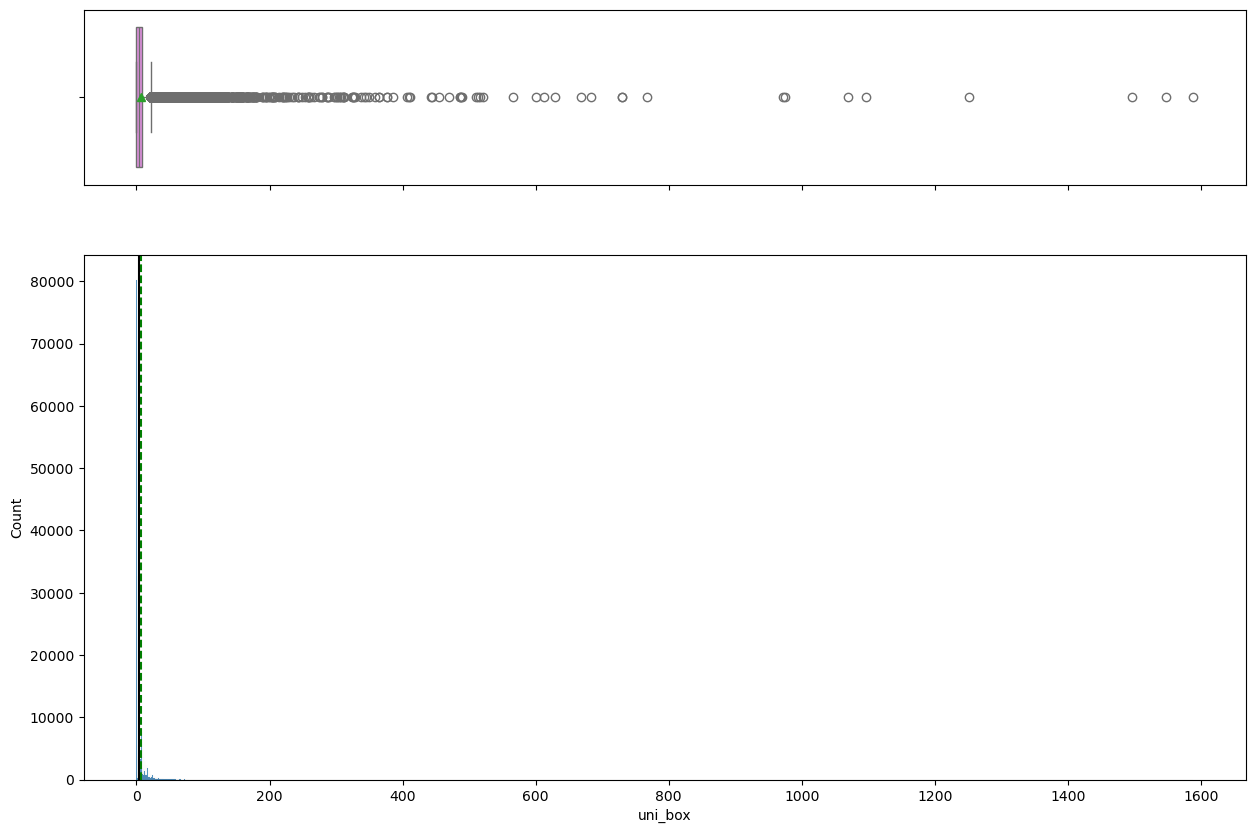

In [401]:
histogram_boxplot(data,'uni_box')

- uni_box has a right-skewed distribution and 0 has the highest count among all observations
- There are many outliers in this variable

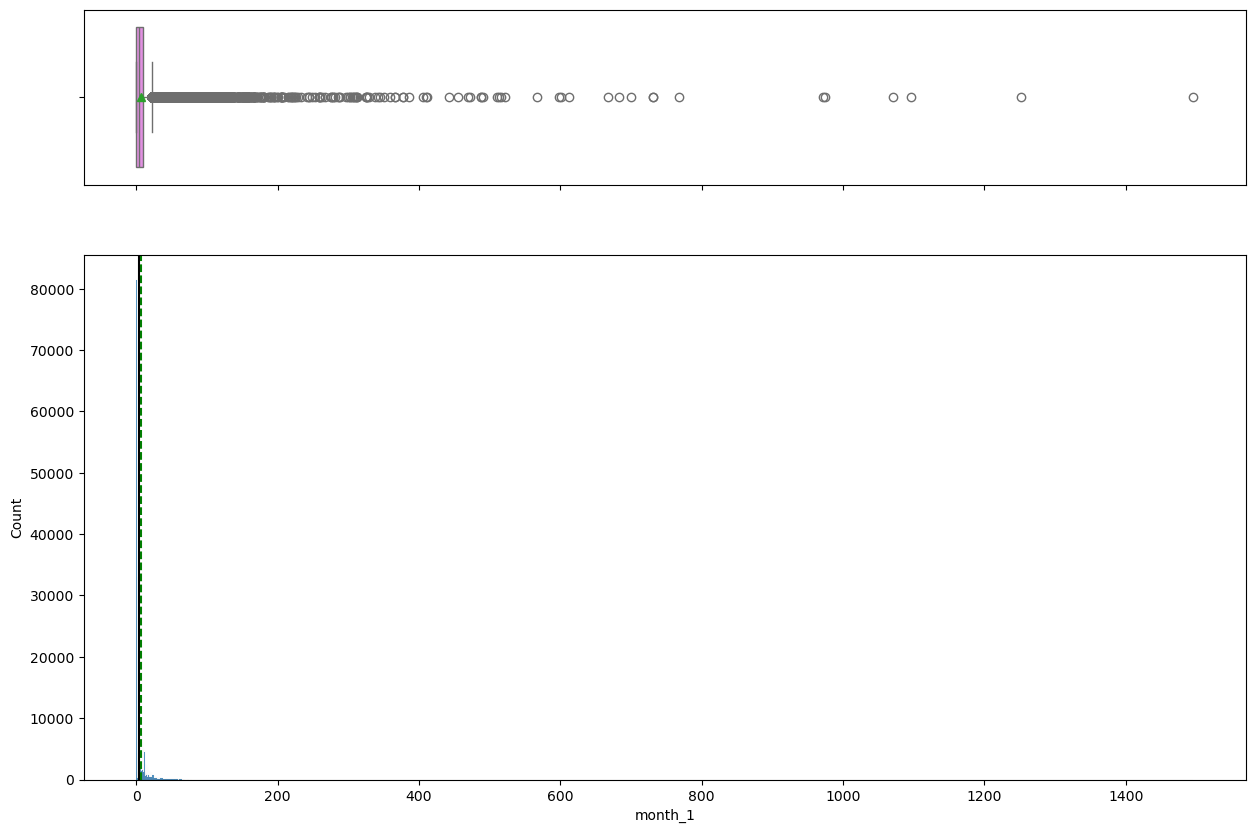

In [403]:
histogram_boxplot(data,'month_1')

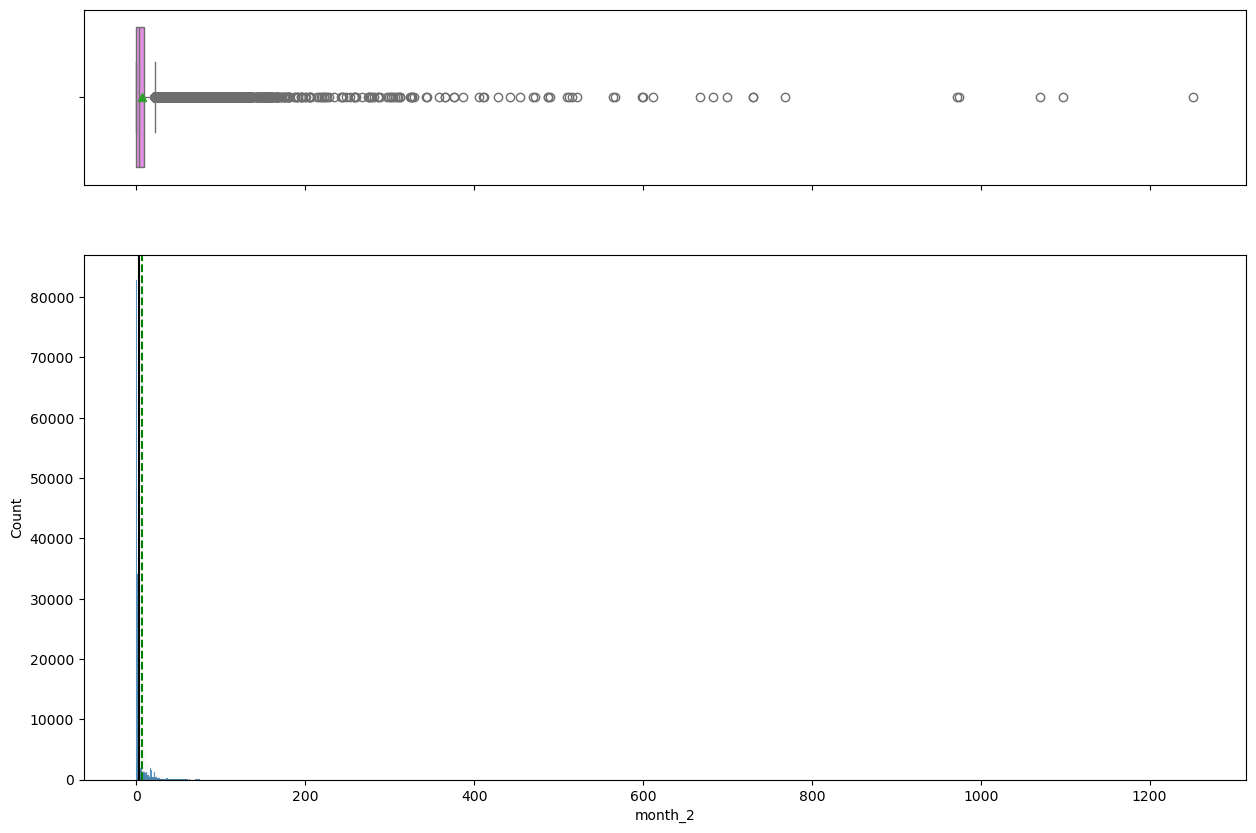

In [404]:
histogram_boxplot(data,'month_2')

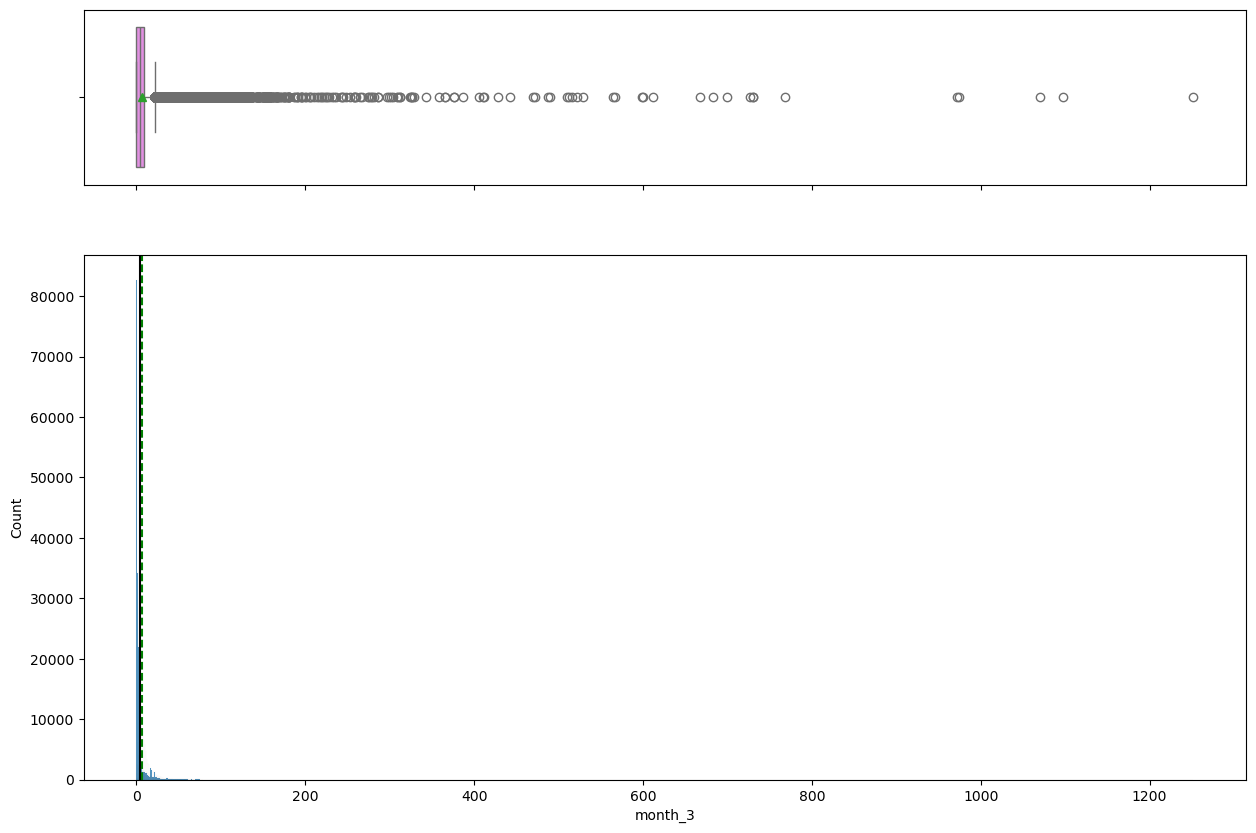

In [405]:
histogram_boxplot(data,'month_3')

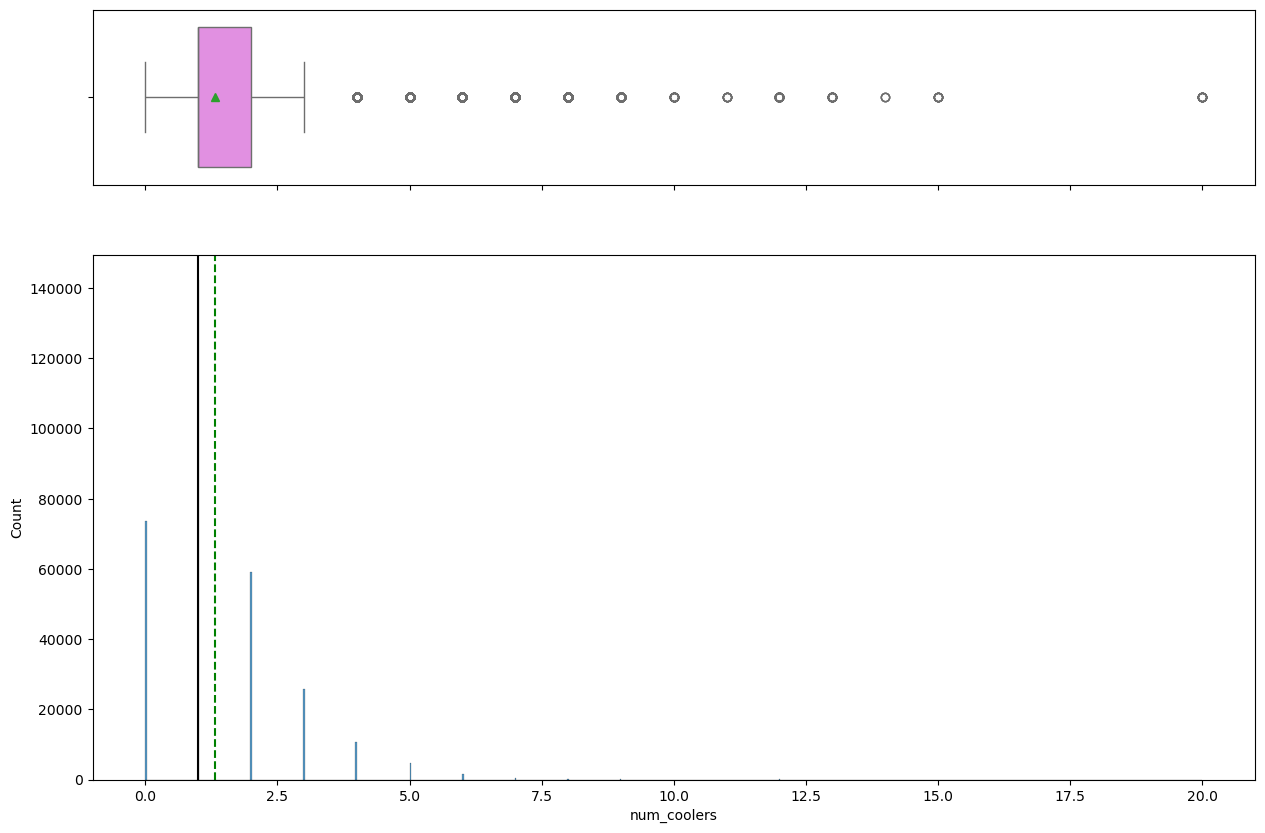

In [406]:
histogram_boxplot(data,'num_coolers')

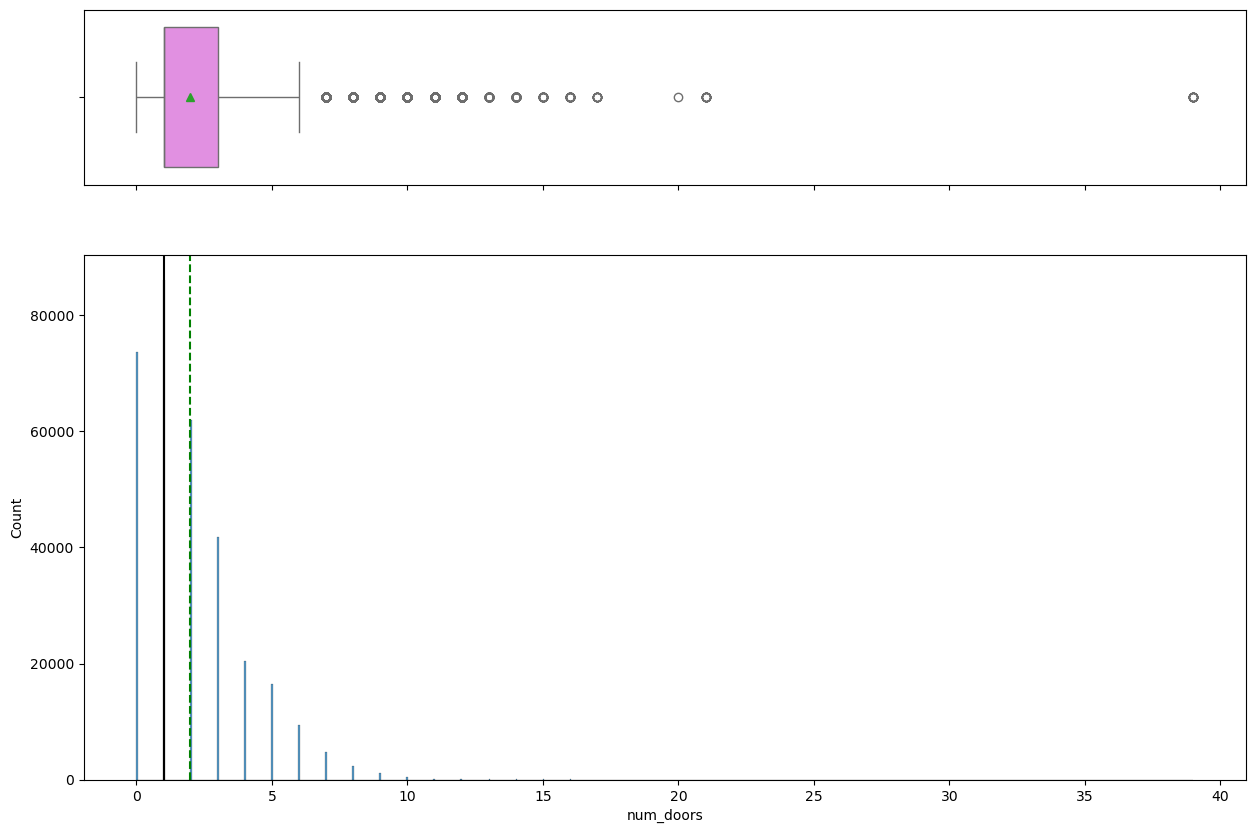

In [407]:
histogram_boxplot(data,'num_doors')

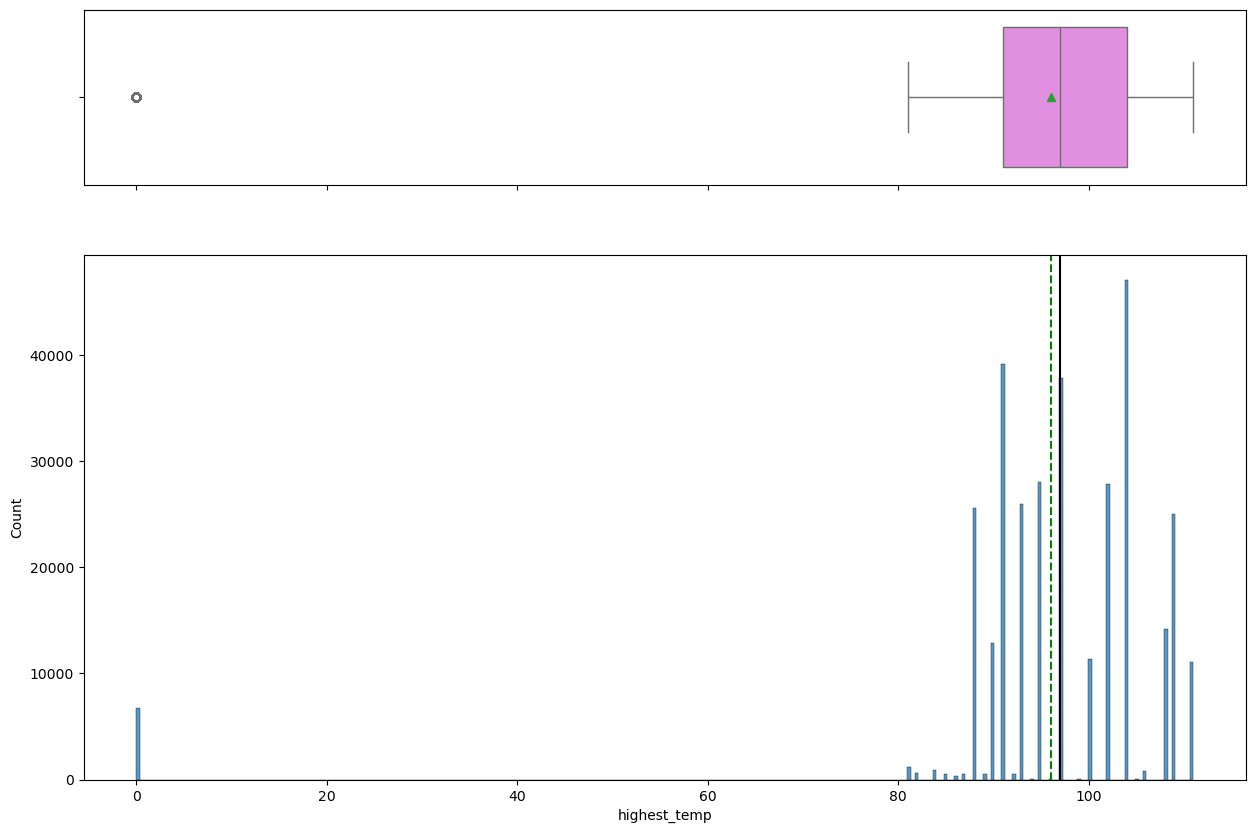

In [408]:
histogram_boxplot(data,'highest_temp')

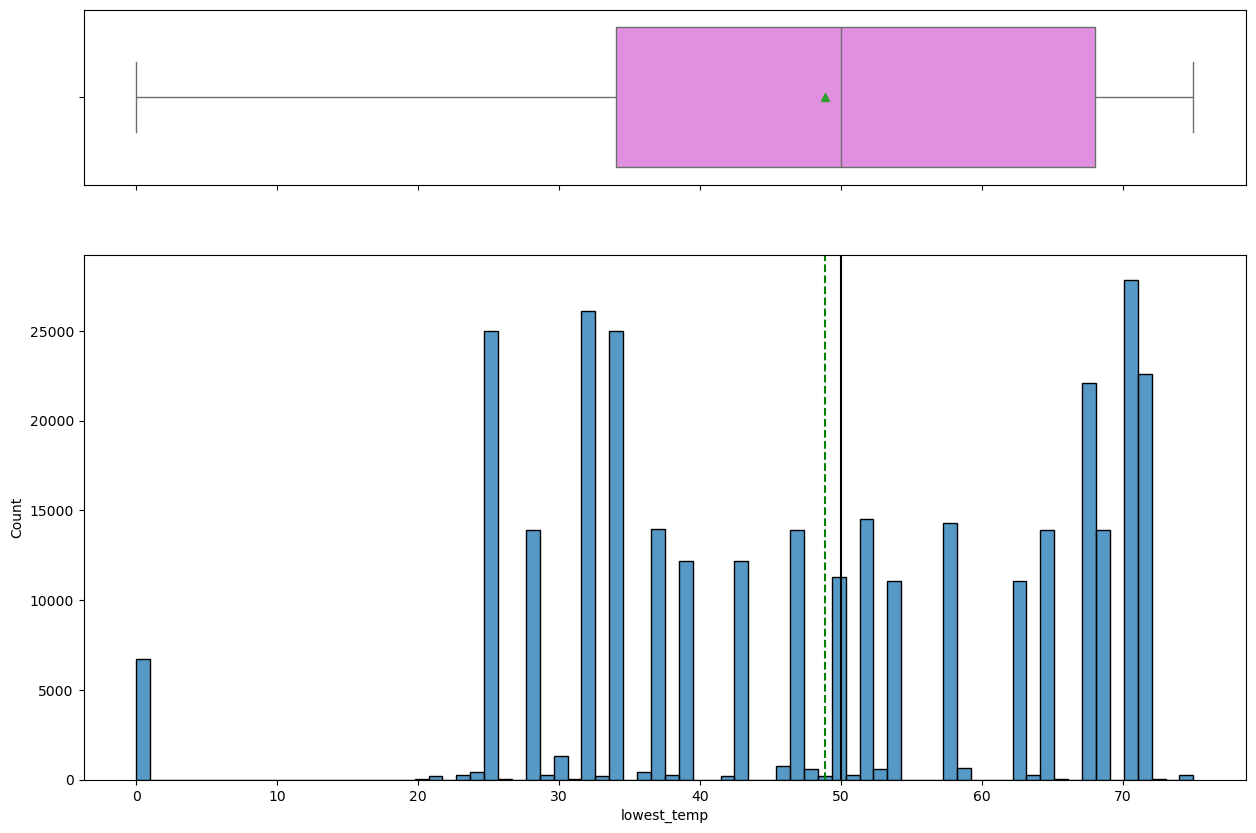

In [409]:
histogram_boxplot(data,'lowest_temp')

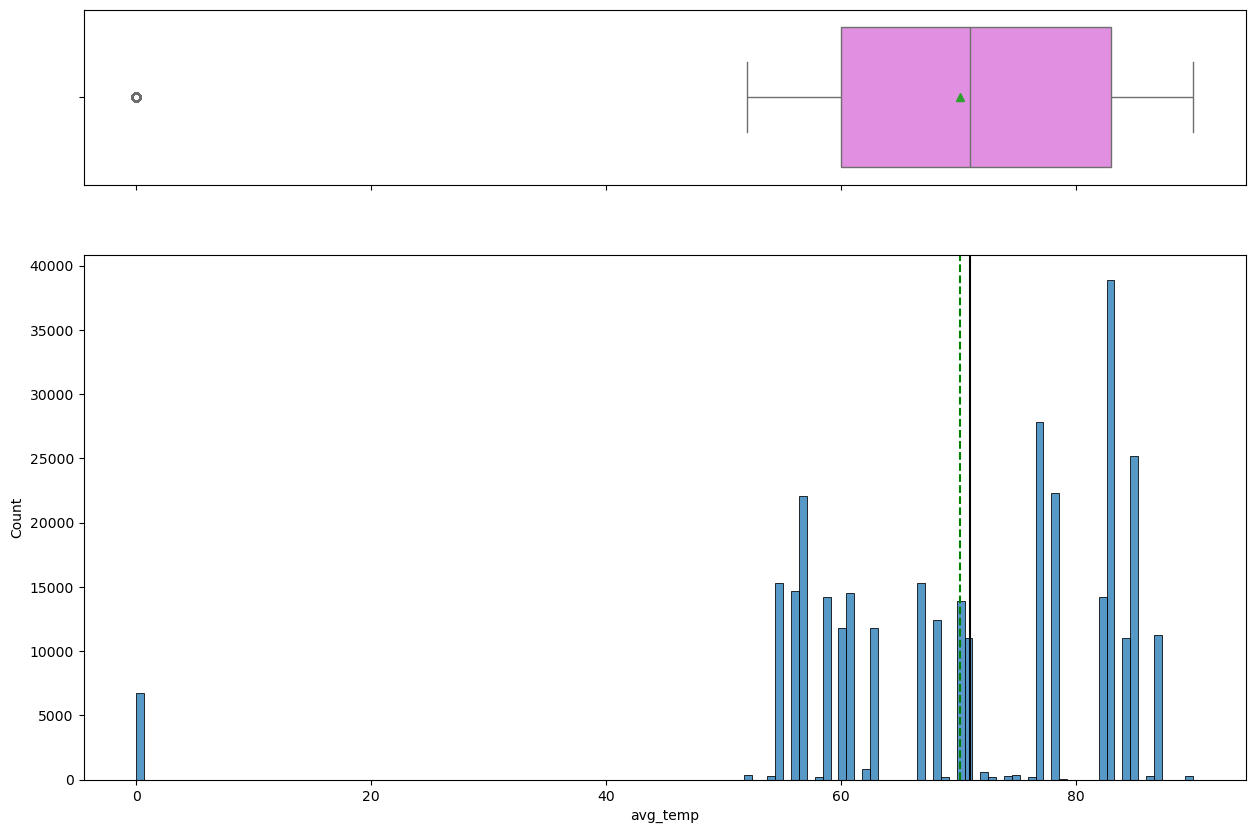

In [410]:
histogram_boxplot(data,'avg_temp')

In [411]:
#Top 5 highest values 
data['uni_box'].nlargest()

Cliente    month
510399038  12       1588.37
510175311  12       1547.57
510711853  11       1495.69
           8        1251.69
510176125  6        1096.77
Name: uni_box, dtype: float64

- The target variable i.e. uni_box feature has a right-skewed distribution
- As evident from the boxplot, there are many outliers

## Bivariate analysis

**Correlation Check**

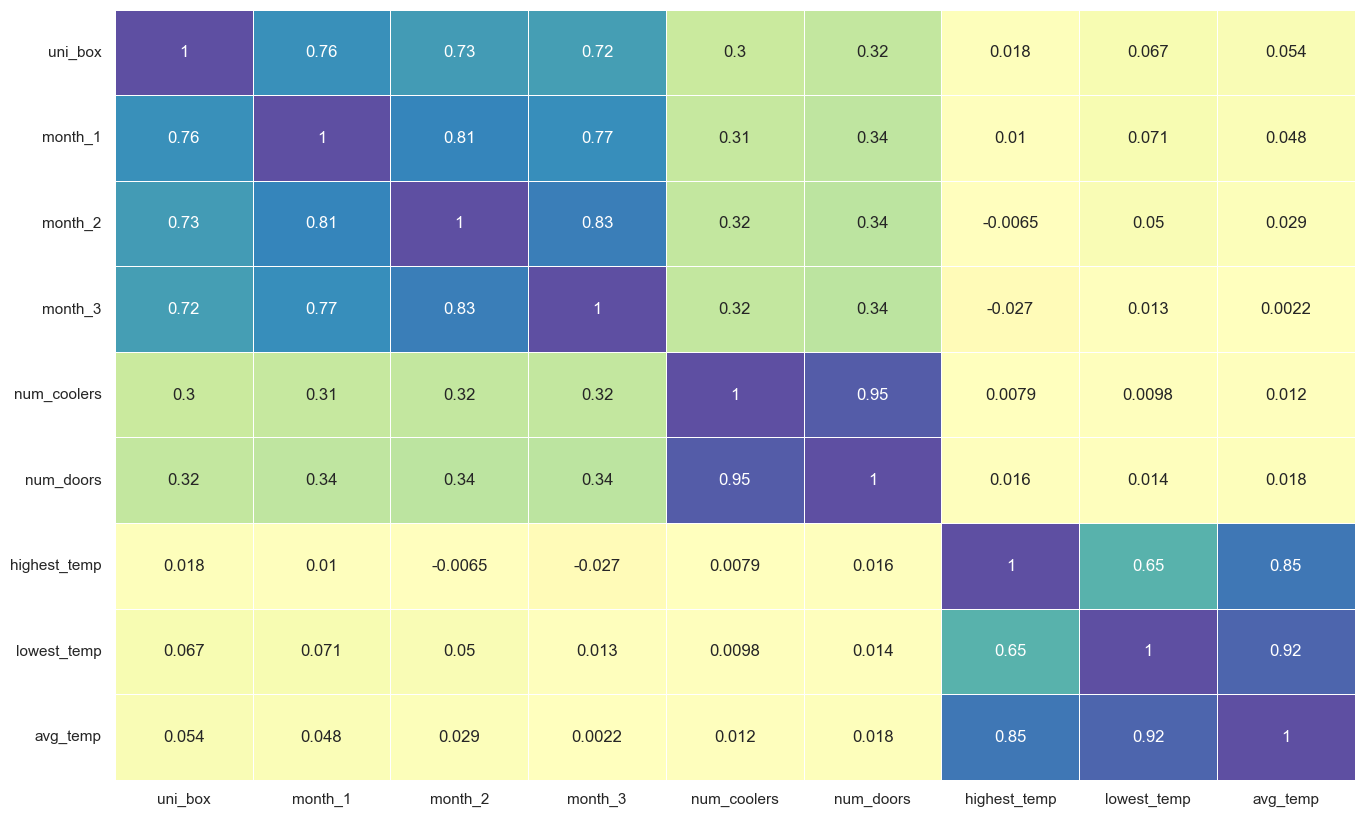

In [415]:
sns.set(rc={'figure.figsize':(16,10)})
sns.heatmap(data.corr(),
            annot=True,
            linewidths=.5,
            center=0,
            cbar=False,
            cmap="Spectral")
plt.show()

- We can see that num_coolers and num_doors are almost perfectly correlated
- Unibox is highly correlated with month-1, month_2, month_3

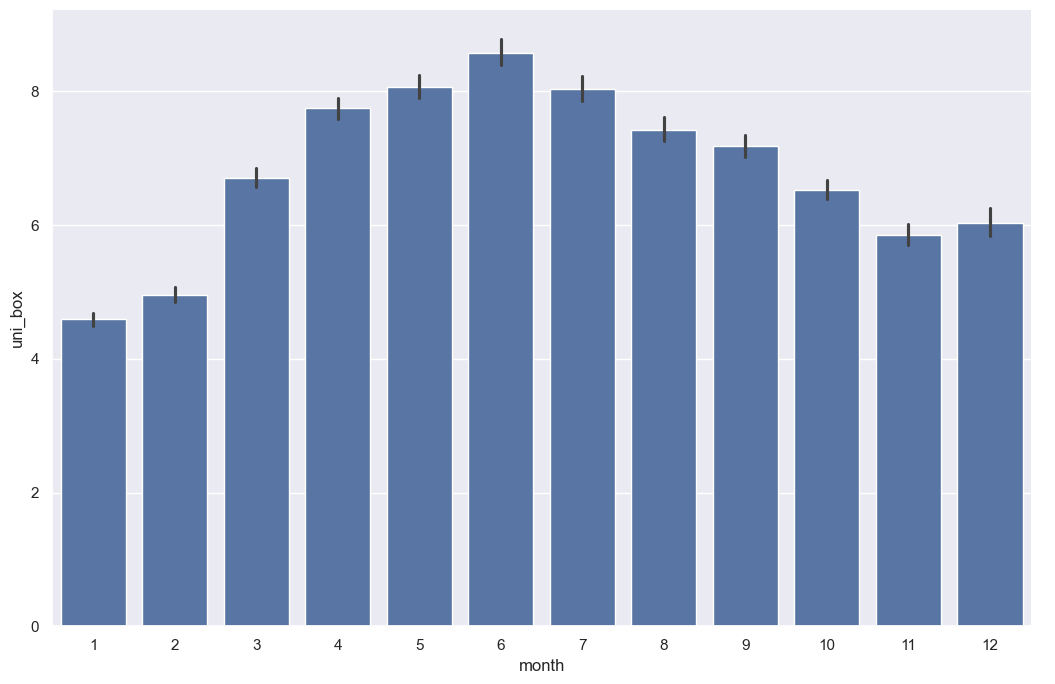

In [417]:
sns.catplot(x="month", y="uni_box", data=data, kind='bar', height=7, aspect=1.5, estimator=np.mean);

- We can see the average number of sales is high for April to Aug month, this can be due to peak season.
- The average number of sales is very low for Jan and Feb

## Data Preprocessing

### Outlier Detection and Treatment

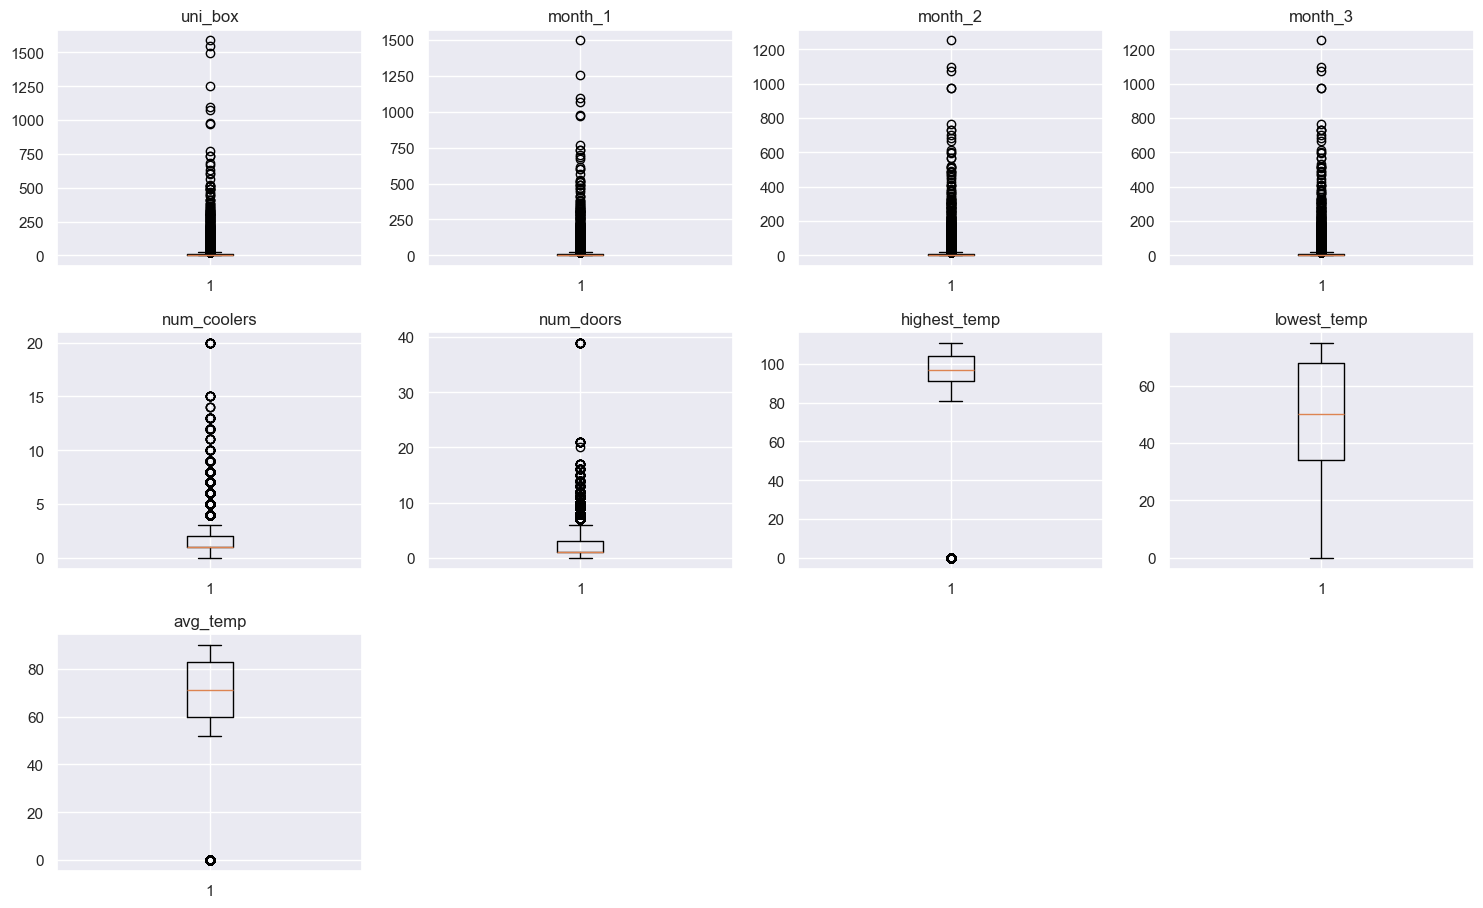

In [421]:
# outlier detection using boxplot
numeric_columns = data.select_dtypes(include=np.number).columns.tolist()


plt.figure(figsize=(15, 12))

for i, variable in enumerate(numeric_columns):
    plt.subplot(4, 4, i + 1)
    plt.boxplot(data[variable], whis=1.5)
    plt.tight_layout()
    plt.title(variable)

plt.show()

- There are quite a few outliers in the data.
- However, we will not treat them as they are proper values.

## Feature Engineering and Feature Selection:

### Data Preparataion for model building

In [425]:
# Correlation Analysis
correlation_matrix = df.corr()
print("Correlation with uni_box:\n", correlation_matrix['uni_box'].sort_values(ascending=False))


Correlation with uni_box:
 uni_box         1.000000
month_1         0.763330
month_2         0.731644
month_3         0.722454
num_doors       0.320097
num_coolers     0.297012
lowest_temp     0.066887
avg_temp        0.053631
highest_temp    0.017796
Name: uni_box, dtype: float64


In [426]:
# Assuming 'sales_coolers_weather' is your original DataFrame
data = sales_coolers_weather.copy()  # Create a copy of the original DataFrame to avoid modifying it directly
data.drop('calmonth', axis=1, inplace=True)  # Remove the 'calmonth' column as it's no longer needed
data.set_index(['Cliente', 'month'], inplace=True)  # Set a multi-index using 'Cliente' and 'month' for better data organization

# Step 1: Split the data into training and testing sets based on month
train_data = data[data.index.get_level_values('month') <= 10]  # Training data includes months 1 to 10
test_data = data[data.index.get_level_values('month') > 10]     # Testing data includes months greater than 10

# Step 2: Feature Engineering Function
def create_features(df):
    # Create lag features for the 'uni_box' variable to capture past values
    df['lag_1'] = df['uni_box'].shift(1)  # Lag of 1 period
    df['lag_2'] = df['uni_box'].shift(2)  # Lag of 2 periods
    df['lag_3'] = df['uni_box'].shift(3)  # Lag of 3 periods
    
    # Calculate rolling statistics for 'uni_box'
    df['rolling_avg_3'] = df['uni_box'].rolling(window=3).mean()  # Rolling average over 3 periods
    df['rolling_sum_3'] = df['uni_box'].rolling(window=3).sum()   # Rolling sum over 3 periods
    
    # Create temperature-related features
    df['temp_range'] = df['highest_temp'] - df['lowest_temp']       # Temperature range
    df['temp_mean'] = (df['highest_temp'] + df['lowest_temp']) / 2   # Mean temperature
    
    # Create an interaction feature between coolers and doors
    df['coolers_doors_interaction'] = df['num_coolers'] * df['num_doors']  # Interaction term
    
    # Drop rows with NaN values created by shifting and rolling calculations
    return df.dropna()  # Return the DataFrame without NaN values

# Step 3: Apply feature engineering to training and testing sets
train_data = create_features(train_data)  # Apply feature engineering to the training set
test_data = create_features(test_data)     # Apply feature engineering to the testing set

# Step 4: Apply log transformation to 'uni_box' for both sets
train_data['uni_box'] = np.log1p(train_data['uni_box'])  # Log transformation to handle zero values safely in training set
test_data['uni_box'] = np.log1p(test_data['uni_box'])    # Log transformation for testing set

# Step 5: Define Features and Target Variable for Training Set
X_train = train_data.drop(columns=['uni_box'])  # Features for training (excluding target variable)
y_train = train_data['uni_box']                  # Target variable for training

X_test = test_data.drop(columns=['uni_box'])     # Features for testing (excluding target variable)
y_test = test_data['uni_box']                     # Target variable for testing

# Step 6: Feature Selection using RFE on Training Set
model = LinearRegression()                         # Initialize the linear regression model
rfe = RFE(model)                                  # Initialize Recursive Feature Elimination (RFE)
rfe.fit(X_train, y_train)                        # Fit RFE on the training set

# Get the selected features based on RFE results
selected_features = X_train.columns[rfe.support_].tolist()  # List of selected features from RFE
print("Selected Features using RFE:", selected_features)      # Print the selected features

# Filter X to only include selected features for both sets
X_train_selected = X_train[selected_features]   # Training features with selected features only
X_test_selected = X_test[selected_features]     # Testing features with selected features only

# Display the shapes of the datasets after feature selection
print("Training set shape:", X_train_selected.shape)   # Print shape of training set
print("Test set shape:", X_test_selected.shape)       # Print shape of test set

Selected Features using RFE: ['num_doors', 'lowest_temp', 'lag_1', 'lag_2', 'rolling_avg_3', 'rolling_sum_3', 'temp_range', 'temp_mean']
Training set shape: (265557, 8)
Test set shape: (53109, 8)


## Bagging - Model Building and Hyperparameter Tuning

- We'll fit different models on the train data and observe their performance. 
- We'll try to improve that performance by tuning some hyperparameters available for that algorithm.
- We'll use RandomizedSearchCV for hyperparameter tuning and `r_2 score` to optimize the model.
- R-square - `Coefficient of determination` is used to evaluate the performance of a regression model. It is the amount of the variation in the output dependent attribute which is predictable from the input independent variables.
- Let's start by creating a function to get model scores, so that we don't have to use the same codes repeatedly.

In [429]:
# function to compute adjusted R-squared
def adj_r2_score(predictors, targets, predictions):
    r2 = r2_score(targets, predictions)
    n = predictors.shape[0]
    k = predictors.shape[1]
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))


# function to compute MAPE
def mape_score(targets, predictions):
    return np.mean(np.abs(targets - predictions) / targets) * 100


# function to compute different metrics to check performance of a regression model
def model_performance_regression(model, predictors, target):
    """
    Function to compute different metrics to check regression model performance

    model: regressor
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    r2 = r2_score(target, pred)  # to compute R-squared
    adjr2 = adj_r2_score(predictors, target, pred)  # to compute adjusted R-squared
    rmse = np.sqrt(mean_squared_error(target, pred))  # to compute RMSE
    mae = mean_absolute_error(target, pred)  # to compute MAE
    mape = mape_score(target, pred)  # to compute MAPE

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "RMSE": rmse,
            "MAE": mae,
            "R-squared": r2,
            "Adj. R-squared": adjr2,
            "MAPE": mape,
        },
        index=[0],
    )

    return df_perf

In [430]:
##  Function to calculate r2_score and RMSE on train and test data
def get_model_score(model, flag=True):
    '''
    model : classifier to predict values of X

    '''
    # defining an empty list to store train and test results
    score_list=[] 
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    train_r2=metrics.r2_score(y_train,pred_train)
    test_r2=metrics.r2_score(y_test,pred_test)
    train_rmse=np.sqrt(metrics.mean_squared_error(y_train,pred_train))
    test_rmse=np.sqrt(metrics.mean_squared_error(y_test,pred_test))
    
    #Adding all scores in the list
    score_list.extend((train_r2,test_r2,train_rmse,test_rmse))
    
    # If the flag is set to True then only the following print statements will be dispayed, the default value is True
    if flag==True: 
        print("R-sqaure on training set : ",metrics.r2_score(y_train,pred_train))
        print("R-square on test set : ",metrics.r2_score(y_test,pred_test))
        print("RMSE on training set : ",np.sqrt(metrics.mean_squared_error(y_train,pred_train)))
        print("RMSE on test set : ",np.sqrt(metrics.mean_squared_error(y_test,pred_test)))
    
    # returning the list with train and test scores
    return score_list

## Models

### Decision Tree Model

In [432]:
dtree=DecisionTreeRegressor(random_state=1)
dtree.fit(X_train,y_train)

DecisionTreeRegressor(random_state=1)

In [433]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [434]:
dtree_model_train_perf=model_performance_regression(dtree, X_train,y_train)
print("Training performance \n",dtree_model_train_perf)

Training performance 
            RMSE           MAE  R-squared  Adj. R-squared          MAPE
0  2.766031e-15  6.525987e-16        1.0             1.0  8.547709e-14


In [435]:
dtree_model_test_perf=model_performance_regression(dtree, X_test,y_test)
print("Testing performance \n",dtree_model_test_perf)

Testing performance 
        RMSE       MAE  R-squared  Adj. R-squared  MAPE
0  0.306006  0.111334    0.91513        0.915105   inf


- The Decision tree model with default parameters is overfitting the train data.
- Let's see if we can reduce overfitting and improve performance on test data by tuning hyperparameters.

### Hyperparameter Tuning

In [438]:
import numpy as np
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics

# Assuming X_train and y_train are already defined

# Choose the type of regressor
dtree_tuned = DecisionTreeRegressor(random_state=1)

# Grid of parameters to choose from
parameters = {
    'max_depth': list(np.arange(2, 20)) + [None], 
    'min_samples_leaf': [1, 3, 5, 7, 10],
    'max_leaf_nodes': [2, 3, 5, 10, 15] + [None],
    'min_impurity_decrease': [0.001, 0.01, 0.1, 0.0]
}

# Type of scoring used to compare parameter combinations (using negative MSE for RMSE)
scorer = metrics.make_scorer(metrics.mean_squared_error, greater_is_better=False)

# Run the grid search
grid_obj = RandomizedSearchCV(dtree_tuned, parameters, scoring=scorer, cv=5)
grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
dtree_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data
dtree_tuned.fit(X_train, y_train)

# Predict on validation set and calculate RMSE
y_test_pred = dtree_tuned.predict(X_test)
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
print("Validation RMSE:", rmse)

Validation RMSE: 0.2635299641380628


In [439]:
dtree_tuned_model_train_perf = model_performance_regression(dtree_tuned, X_train,y_train)
print("Training performance \n",dtree_tuned_model_train_perf)

Training performance 
        RMSE       MAE  R-squared  Adj. R-squared  MAPE
0  0.132429  0.065711   0.985973        0.985972   inf


In [440]:
dtree_tuned_model_test_perf = model_performance_regression(dtree_tuned, X_test,y_test)
print("Testing performance \n",dtree_tuned_model_test_perf)

Testing performance 
       RMSE       MAE  R-squared  Adj. R-squared  MAPE
0  0.26353  0.131602   0.937056        0.937037   inf


**Plotting the feature importance of each variable**

In [442]:
# importance of features in the tree building ( The importance of a feature is computed as the 
#(normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance )

print(pd.DataFrame(dtree_tuned.feature_importances_, columns = ["Imp"], index = X_train.columns).sort_values(by = 'Imp', ascending = False))

                                Imp
rolling_sum_3              0.622106
rolling_avg_3              0.211483
lag_2                      0.058767
lag_1                      0.057937
month_1                    0.041107
highest_temp               0.004155
month_2                    0.003451
month_3                    0.000534
lag_3                      0.000164
num_doors                  0.000079
coolers_doors_interaction  0.000075
lowest_temp                0.000058
temp_range                 0.000036
num_coolers                0.000017
avg_temp                   0.000017
temp_mean                  0.000016


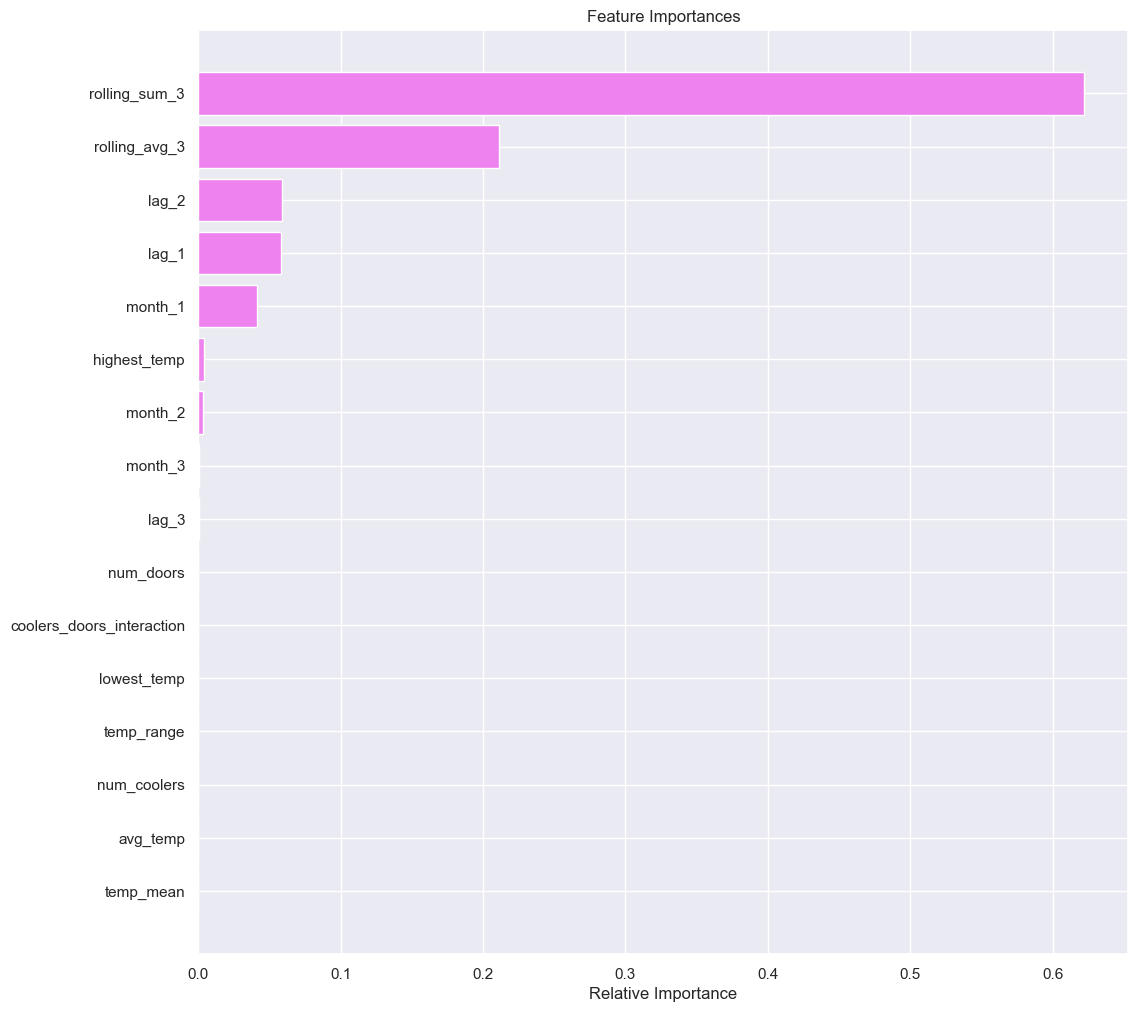

In [443]:
feature_names = X_train.columns
importances = dtree_tuned.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

- rolling_sum_3 is the most important feature, in addition to rolling_avg_3, for tuned decision tree model

### Random Forest Model

In [446]:
rf_estimator=RandomForestRegressor(random_state=1)
rf_estimator.fit(X_train,y_train)

RandomForestRegressor(random_state=1)

In [447]:
rf_estimator_model_train_perf = model_performance_regression(rf_estimator, X_train,y_train)
print("Training performance \n",rf_estimator_model_train_perf)

Training performance 
        RMSE       MAE  R-squared  Adj. R-squared  MAPE
0  0.033761  0.008998   0.999088        0.999088   inf


In [448]:
rf_estimator_model_test_perf = model_performance_regression(rf_estimator, X_test,y_test)
print("Testing performance \n",rf_estimator_model_test_perf)

Testing performance 
        RMSE       MAE  R-squared  Adj. R-squared  MAPE
0  0.189365  0.073338   0.967499        0.967489   inf


- Random forest is giving a good r2 score of 96% on the test data but it is slightly overfitting the train data.
- Let's try to reduce this overfitting by hyperparameter tuning.

### Hyperparameter Tuning

In [451]:
# Choose the type of classifier. 
rf_tuned = RandomForestRegressor(random_state=1)

# Grid of parameters to choose from
parameters = {  
                'max_depth':[4, 6, 8, 10, None],
                'max_features': ['sqrt','log2',None],
                'n_estimators': [80, 90, 100, 110, 120]
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.r2_score)

# Run the grid search
grid_obj = RandomizedSearchCV(rf_tuned, parameters, scoring=scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
rf_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
rf_tuned.fit(X_train, y_train)

RandomForestRegressor(max_features='sqrt', n_estimators=120, random_state=1)

In [452]:
rf_tuned_model_train_perf = model_performance_regression(rf_tuned, X_train, y_train)
print("Training performance \n",rf_tuned_model_train_perf)

Training performance 
        RMSE      MAE  R-squared  Adj. R-squared  MAPE
0  0.062624  0.03246   0.996863        0.996863   inf


In [453]:
rf_tuned_model_test_perf = model_performance_regression(rf_tuned, X_test, y_test)
print("Testing performance \n",rf_tuned_model_test_perf)

Testing performance 
       RMSE       MAE  R-squared  Adj. R-squared  MAPE
0  0.30246  0.195627   0.917086        0.917061   inf


In [455]:
# importance of features in the tree building ( The importance of a feature is computed as the 
#(normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance )

print(pd.DataFrame(rf_tuned.feature_importances_, columns = ["Imp"], index = X_train.columns).sort_values(by = 'Imp', ascending = False))

                                Imp
rolling_avg_3              0.247474
rolling_sum_3              0.241995
month_1                    0.155101
month_2                    0.088923
lag_1                      0.079121
month_3                    0.073512
lag_2                      0.062115
lag_3                      0.017034
coolers_doors_interaction  0.006888
highest_temp               0.006139
temp_mean                  0.003958
num_coolers                0.003770
lowest_temp                0.003768
temp_range                 0.003716
avg_temp                   0.003666
num_doors                  0.002818


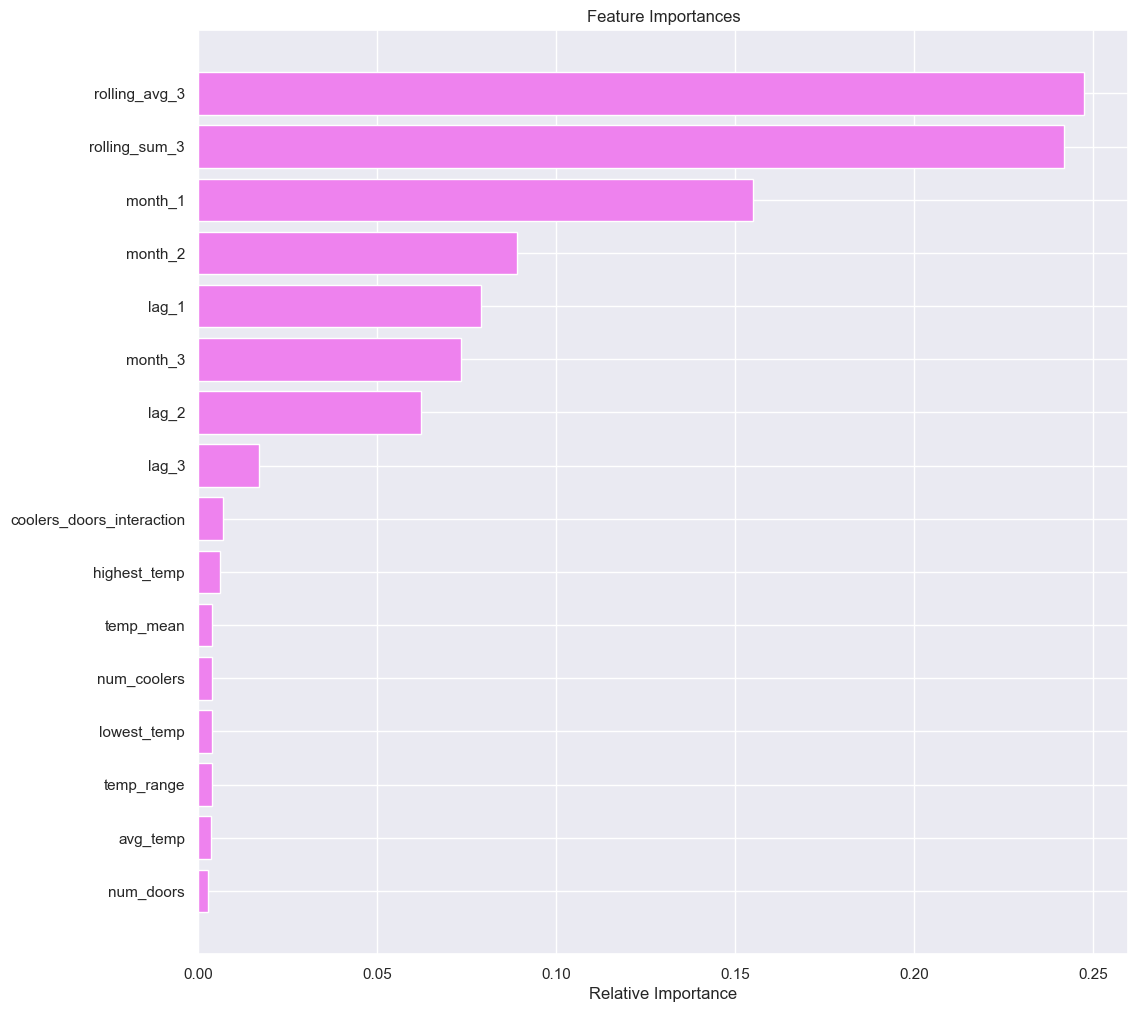

In [456]:
feature_names = X_train.columns
importances = rf_tuned.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## Boosting - Model Building and Hyperparameter Tuning

### AdaBoost Regressor

In [459]:
ab_regressor=AdaBoostRegressor(random_state=1)
ab_regressor.fit(X_train,y_train)

AdaBoostRegressor(random_state=1)

In [460]:
ab_regressor_model_train_perf = model_performance_regression(ab_regressor, X_train,y_train)
print("Training performance \n",ab_regressor_model_train_perf)

Training performance 
        RMSE       MAE  R-squared  Adj. R-squared  MAPE
0  0.729412  0.637838   0.574462        0.574436   inf


In [461]:
ab_regressor_model_test_perf = model_performance_regression(ab_regressor, X_test,y_test)
print("Testing performance \n",ab_regressor_model_test_perf)

Testing performance 
       RMSE       MAE  R-squared  Adj. R-squared  MAPE
0  0.73686  0.640471    0.50789        0.507741   inf


- AdaBoost is generalizing well but it is giving poor performance, in terms of r2 score as well as RMSE, as compared to the decision tree and random forest model.  

### Hyperparameter Tuning

In [464]:
# Choose the type of classifier. 
ab_tuned = AdaBoostRegressor(random_state=1)

# Grid of parameters to choose from
parameters = {'n_estimators': np.arange(10,100,10), 
              'learning_rate': [1, 0.1, 0.5, 0.01],
              }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.r2_score)

# Run the grid search
grid_obj = RandomizedSearchCV(ab_tuned, parameters, scoring=scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
ab_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
ab_tuned.fit(X_train, y_train)

AdaBoostRegressor(learning_rate=0.1, n_estimators=60, random_state=1)

In [465]:
ab_tuned_model_train_perf = model_performance_regression(ab_tuned, X_train,y_train)
print("Training performance \n",ab_tuned_model_train_perf)

Training performance 
        RMSE       MAE  R-squared  Adj. R-squared  MAPE
0  0.458186  0.353775    0.83209         0.83208   inf


In [466]:
ab_tuned_model_test_perf = model_performance_regression(ab_tuned, X_test,y_test)
print("Testing performance \n",ab_tuned_model_test_perf)

Testing performance 
        RMSE       MAE  R-squared  Adj. R-squared  MAPE
0  0.591954  0.479011    0.68241        0.682314   inf


In [467]:
# importance of features in the tree building

print(pd.DataFrame(ab_tuned.feature_importances_, columns = ["Imp"], index = X_train.columns).sort_values(by = 'Imp', ascending = False))

                                Imp
rolling_avg_3              0.429052
rolling_sum_3              0.389333
month_1                    0.105030
month_2                    0.035838
lag_2                      0.029844
month_3                    0.007247
temp_range                 0.001876
highest_temp               0.001781
num_coolers                0.000000
num_doors                  0.000000
lowest_temp                0.000000
avg_temp                   0.000000
lag_1                      0.000000
lag_3                      0.000000
temp_mean                  0.000000
coolers_doors_interaction  0.000000


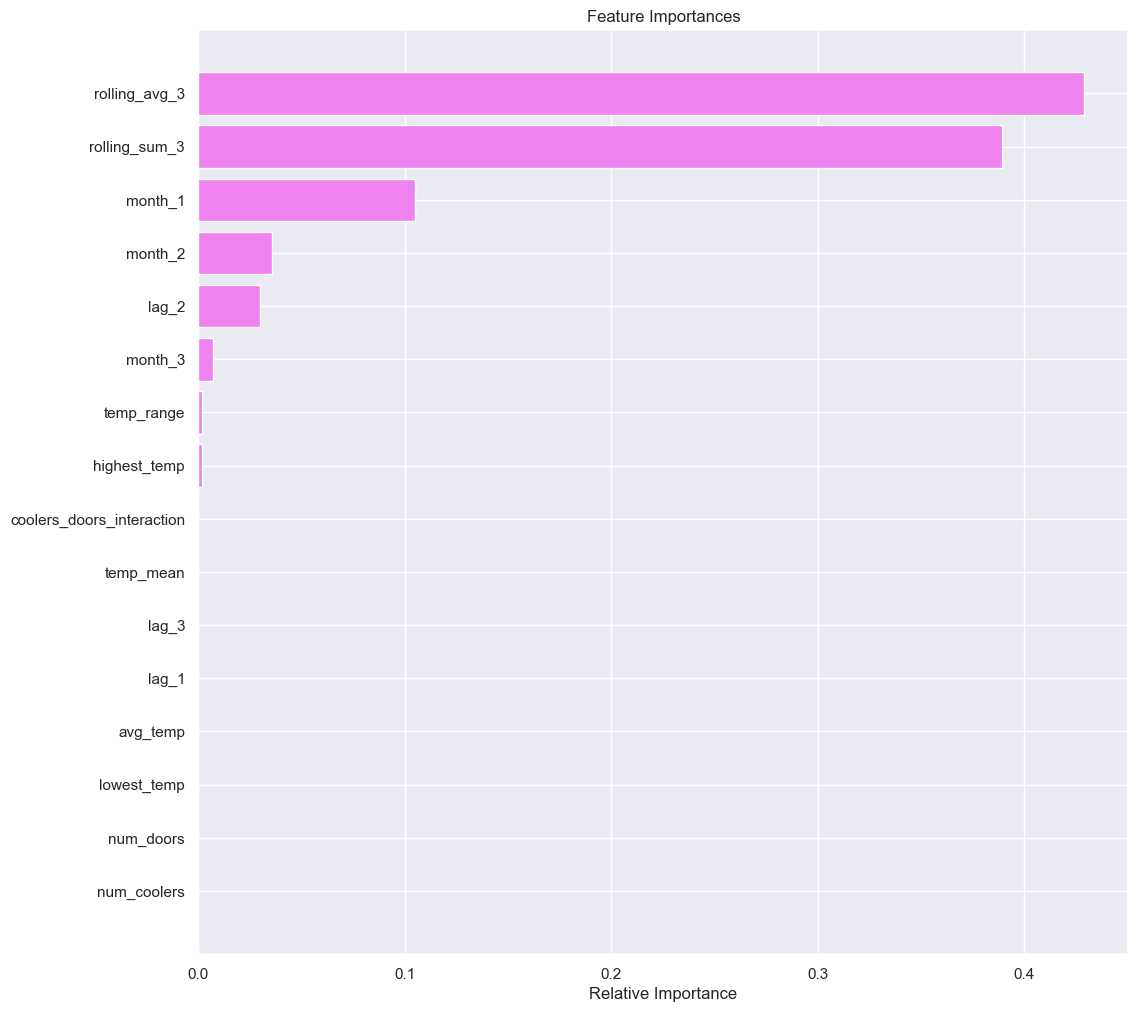

In [468]:
feature_names = X_train.columns
importances = ab_tuned.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Gradient Boosting Regressor

In [470]:
gb_estimator=GradientBoostingRegressor(random_state=1)
gb_estimator.fit(X_train,y_train)

GradientBoostingRegressor(random_state=1)

In [471]:
gb_estimator_model_train_perf = model_performance_regression(gb_estimator, X_train,y_train)
print("Training performance \n",gb_estimator_model_train_perf)

Training performance 
        RMSE       MAE  R-squared  Adj. R-squared  MAPE
0  0.269506  0.183422   0.941906        0.941903   inf


In [472]:
gb_estimator_model_test_perf = model_performance_regression(gb_estimator, X_test, y_test)
print("Testing performance \n",gb_estimator_model_test_perf)

Testing performance 
        RMSE       MAE  R-squared  Adj. R-squared  MAPE
0  0.334809  0.231622   0.898402        0.898371   inf


### Hyperparameter Tuning

In [474]:
# Choose the type of classifier. 
gb_tuned = GradientBoostingRegressor(random_state=1)

# Grid of parameters to choose from
parameters = {'n_estimators': np.arange(50,200,25), 
              'subsample':[0.7,0.8,0.9,1],
              'max_features':[0.7,0.8,0.9,1],
              'max_depth':[3,5,7,10]
              }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.r2_score)

# Run the random search
grid_obj = RandomizedSearchCV(gb_tuned, parameters, scoring=scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
gb_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
gb_tuned.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=10, max_features=0.9, n_estimators=50,
                          random_state=1, subsample=0.9)

In [475]:
gb_tuned_model_train_perf = model_performance_regression(gb_tuned, X_train,y_train)
print("Training performance \n",gb_tuned_model_train_perf)

Training performance 
        RMSE       MAE  R-squared  Adj. R-squared  MAPE
0  0.041645  0.023802   0.998613        0.998613   inf


In [476]:
gb_tuned_model_test_perf = model_performance_regression(gb_tuned, X_test, y_test)
print("Testing performance \n",gb_tuned_model_test_perf)

Testing performance 
        RMSE       MAE  R-squared  Adj. R-squared  MAPE
0  0.139343  0.061953   0.982402        0.982397   inf


In [477]:
# importance of features in the tree building ( The importance of a feature is computed as the 
#(normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance )

print(pd.DataFrame(gb_tuned.feature_importances_, columns = ["Imp"], index = X_train.columns).sort_values(by = 'Imp', ascending = False))

                                Imp
rolling_avg_3              0.424430
rolling_sum_3              0.401056
lag_2                      0.063939
lag_1                      0.060685
month_1                    0.034330
month_2                    0.008273
highest_temp               0.004122
month_3                    0.001324
lag_3                      0.000896
temp_range                 0.000300
coolers_doors_interaction  0.000158
temp_mean                  0.000138
lowest_temp                0.000107
avg_temp                   0.000100
num_doors                  0.000083
num_coolers                0.000060


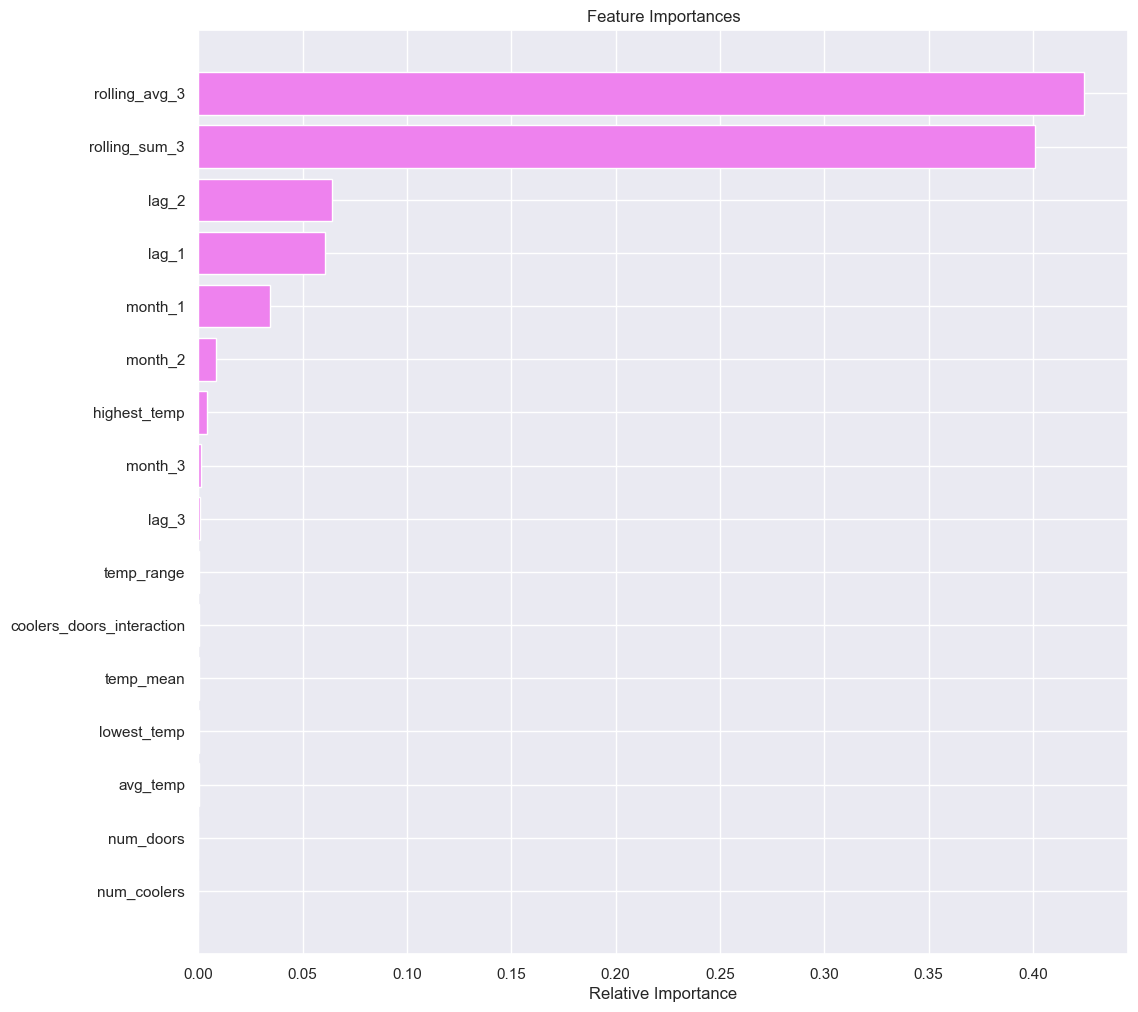

In [478]:
feature_names = X_train.columns
importances = gb_tuned.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### XGBoost Regressor

In [480]:
xgb_estimator=XGBRegressor(random_state=1, verbosity = 0)
xgb_estimator.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=1, ...)

In [481]:
xgb_estimator_model_train_perf = model_performance_regression(xgb_estimator, X_train, y_train)
print("Training performance \n",xgb_estimator_model_train_perf)

Training performance 
        RMSE       MAE  R-squared  Adj. R-squared  MAPE
0  0.081341  0.048751   0.994708        0.994708   inf


In [482]:
xgb_estimator_model_test_perf = model_performance_regression(xgb_estimator, X_test,y_test)
print("Testing performance \n",xgb_estimator_model_test_perf)

Testing performance 
        RMSE       MAE  R-squared  Adj. R-squared  MAPE
0  0.155347  0.089087   0.978127        0.978121   inf


- XGBoost with default parameters is giving almost as good results as the tuned gradient boosting model.

### Hyperparameter Tuning

In [485]:
# Choose the type of classifier. 
xgb_tuned = XGBRegressor(random_state=1, verbosity = 0)

# Grid of parameters to choose from
parameters = {'n_estimators': [75,100,125,150], 
              'subsample':[0.7, 0.8, 0.9, 1],
              'gamma':[0, 1, 3, 5],
              'colsample_bytree':[0.7, 0.8, 0.9, 1],
              'colsample_bylevel':[0.7, 0.8, 0.9, 1]
              }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.r2_score)

# Run the grid search
grid_obj = RandomizedSearchCV(xgb_tuned, parameters, scoring=scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
xgb_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
xgb_tuned.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=150,
             n_jobs=None, num_parallel_tree=None, random_state=1, ...)

In [486]:
xgb_tuned_model_train_perf = model_performance_regression(xgb_tuned, X_train, y_train)
print("Training performance \n",xgb_tuned_model_train_perf)

Training performance 
        RMSE       MAE  R-squared  Adj. R-squared  MAPE
0  0.073343  0.045151   0.995698        0.995697   inf


In [487]:
xgb_tuned_model_test_perf = model_performance_regression(xgb_tuned, X_test, y_test)
print("Testing performance \n",xgb_tuned_model_test_perf)

Testing performance 
        RMSE       MAE  R-squared  Adj. R-squared  MAPE
0  0.149893  0.086157   0.979637         0.97963   inf


In [488]:
# importance of features in the tree building ( The importance of a feature is computed as the 
#(normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance )

print(pd.DataFrame(xgb_tuned.feature_importances_, columns = ["Imp"], index = X_train.columns).sort_values(by = 'Imp', ascending = False))

                                Imp
rolling_avg_3              0.579025
rolling_sum_3              0.167891
month_1                    0.076365
lag_1                      0.047259
lag_2                      0.045278
highest_temp               0.025680
month_2                    0.024243
month_3                    0.011016
temp_range                 0.006088
lag_3                      0.004413
lowest_temp                0.003638
avg_temp                   0.003358
temp_mean                  0.002190
num_coolers                0.001706
num_doors                  0.001073
coolers_doors_interaction  0.000777


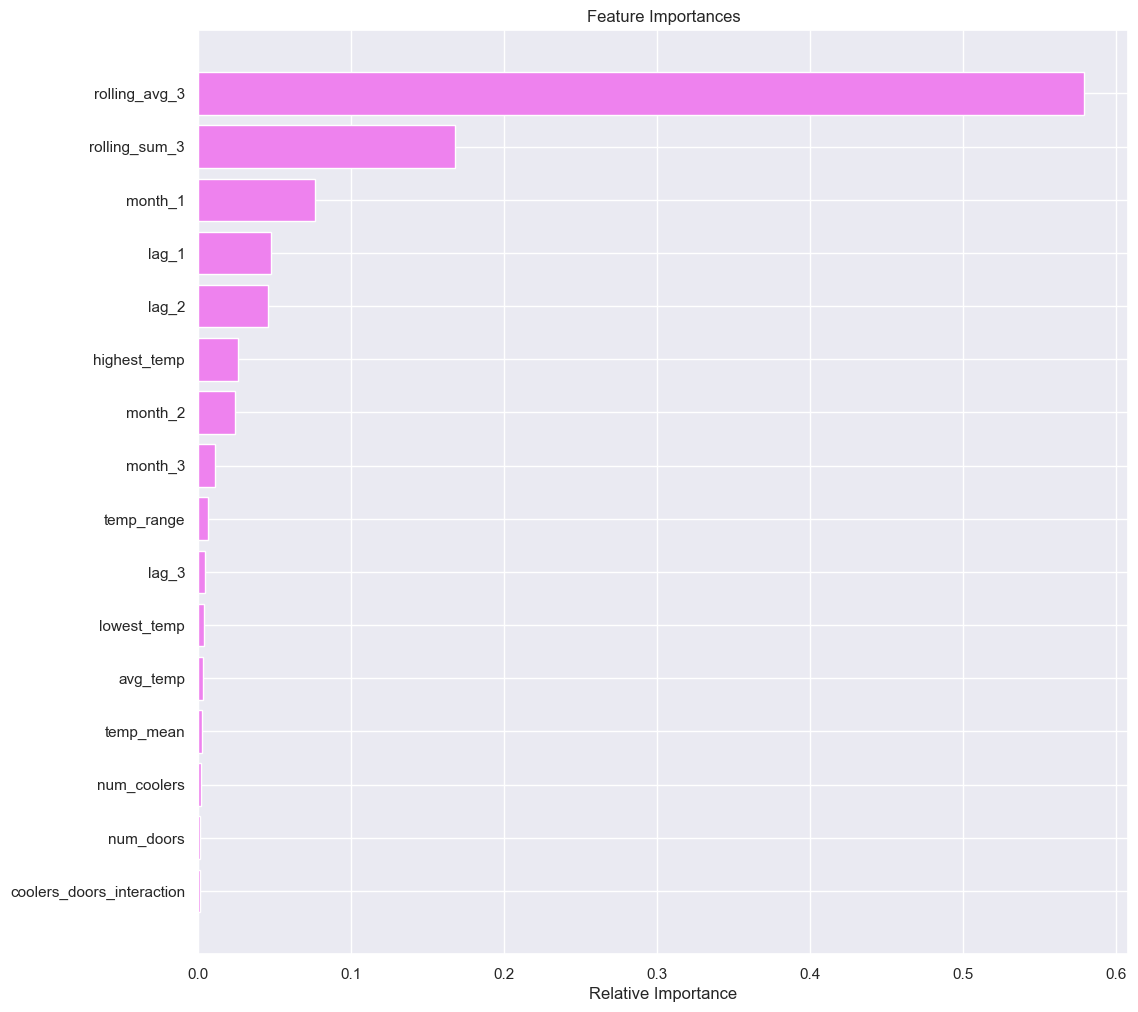

In [489]:
feature_names = X_train.columns
importances = xgb_tuned.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

- In XGBoost, rolling_avg_3 is the most important feature followed by features - rolling_sum_3 and month_1

## Stacking Model

**Now, let's build a stacking model with the tuned models - decision tree, random forest, and gradient boosting, then use XGBoost to get the final prediction.**

In [493]:
estimators=[('Decision Tree', dtree_tuned),('Random Forest', rf_tuned),
           ('Gradient Boosting', gb_tuned)]
final_estimator=XGBRegressor(random_state=1)

In [494]:
stacking_estimator=StackingRegressor(estimators=estimators, final_estimator=final_estimator,cv=5)
stacking_estimator.fit(X_train,y_train)

StackingRegressor(cv=5,
                  estimators=[('Decision Tree',
                               DecisionTreeRegressor(max_depth=13,
                                                     min_samples_leaf=10,
                                                     random_state=1)),
                              ('Random Forest',
                               RandomForestRegressor(max_features='sqrt',
                                                     n_estimators=120,
                                                     random_state=1)),
                              ('Gradient Boosting',
                               GradientBoostingRegressor(max_depth=10,
                                                         max_features=0.9,
                                                         n_estimators=50,
                                                         random_state=1,
                                                         subsample=0.9))],
                  final_estim...
                                               feature_types=None, gamma=None,
                                               grow_policy=None,
                                               importance_type=None,
                                               interaction_constraints=None,
                                               learning_rate=None, max_bin=None,
                                               max_cat_threshold=None,
                                               max_cat_to_onehot=None,
                                               max_delta_step=None,
                                               max_depth=None, max_leaves=None,
                                               min_child_weight=None,
                                               missing=nan,
                                               monotone_constraints=None,
                                               multi_strategy=None,
                                               n_estimators=None, n_jobs=None,
                                               num_parallel_tree=None,
                                               random_state=1, ...))

In [495]:
stacking_estimator_model_train_perf = model_performance_regression(stacking_estimator, X_train, y_train)
print("Training performance \n",stacking_estimator_model_train_perf)

Training performance 
        RMSE       MAE  R-squared  Adj. R-squared  MAPE
0  0.046866  0.019408   0.998243        0.998243   inf


In [496]:
stacking_estimator_model_test_perf = model_performance_regression(stacking_estimator, X_test, y_test)
print("Testing performance \n",stacking_estimator_model_test_perf)

Testing performance 
        RMSE       MAE  R-squared  Adj. R-squared  MAPE
0  0.139319  0.054709   0.982408        0.982403   inf


## Comparing all models

In [498]:
# training performance comparison

models_train_comp_df = pd.concat(
    [dtree_model_train_perf.T, dtree_tuned_model_train_perf.T, rf_estimator_model_train_perf.T,rf_tuned_model_train_perf.T,
    ab_regressor_model_train_perf.T,ab_tuned_model_train_perf.T,gb_estimator_model_train_perf.T,gb_tuned_model_train_perf.T,
    xgb_estimator_model_train_perf.T,xgb_tuned_model_train_perf.T,stacking_estimator_model_train_perf.T],
    axis=1,
)

models_train_comp_df.columns = [
    "Decision Tree",
    "Decision Tree Tuned",
    "Random Forest Estimator",
    "Random Forest Tuned",
    "Adaboost Regressor",
    "Adaboost Tuned",
    "Gradient Boost Estimator",
    "Gradient Boost Tuned",
    "XGB",
    "XGB Tuned",
    "Stacking Classifier"
]

print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Decision Tree,Decision Tree Tuned,Random Forest Estimator,Random Forest Tuned,Adaboost Regressor,Adaboost Tuned,Gradient Boost Estimator,Gradient Boost Tuned,XGB,XGB Tuned,Stacking Classifier
RMSE,2.766031e-15,0.132429,0.033761,0.062624,0.729412,0.458186,0.269506,0.041645,0.081341,0.073343,0.046866
MAE,6.525987e-16,0.065711,0.008998,0.032460,0.637838,0.353775,0.183422,0.023802,0.048751,0.045151,0.019408
R-squared,1.000000e+00,0.985973,0.999088,0.996863,0.574462,0.832090,0.941906,0.998613,0.994708,0.995698,0.998243
Adj. R-squared,1.000000e+00,0.985972,0.999088,0.996863,0.574436,0.832080,0.941903,0.998613,0.994708,0.995697,0.998243
MAPE,8.547709e-14,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf


In [499]:
# Testing performance comparison

models_test_comp_df = pd.concat(
    [dtree_model_test_perf.T, dtree_tuned_model_test_perf.T, rf_estimator_model_test_perf.T,rf_tuned_model_test_perf.T,
    ab_regressor_model_test_perf.T,ab_tuned_model_test_perf.T,gb_estimator_model_test_perf.T,gb_tuned_model_test_perf.T,
    xgb_estimator_model_test_perf.T,xgb_tuned_model_test_perf.T,stacking_estimator_model_test_perf.T],
    axis=1,
)

models_test_comp_df.columns = [
    "Decision Tree",
    "Decision Tree Tuned",
    "Random Forest Estimator",
    "Random Forest Tuned",
    "Adaboost Regressor",
    "Adaboost Tuned",
    "Gradient Boost Estimator",
    "Gradient Boost Tuned",
    "XGB",
    "XGB Tuned",
    "Stacking Classifier"
]

print("Testing performance comparison:")
models_test_comp_df

Testing performance comparison:


,Decision Tree,Decision Tree Tuned,Random Forest Estimator,Random Forest Tuned,Adaboost Regressor,Adaboost Tuned,Gradient Boost Estimator,Gradient Boost Tuned,XGB,XGB Tuned,Stacking Classifier
RMSE,0.306006,0.263530,0.189365,0.302460,0.736860,0.591954,0.334809,0.139343,0.155347,0.149893,0.139319
MAE,0.111334,0.131602,0.073338,0.195627,0.640471,0.479011,0.231622,0.061953,0.089087,0.086157,0.054709
R-squared,0.915130,0.937056,0.967499,0.917086,0.507890,0.682410,0.898402,0.982402,0.978127,0.979637,0.982408
Adj. R-squared,0.915105,0.937037,0.967489,0.917061,0.507741,0.682314,0.898371,0.982397,0.978121,0.979630,0.982403
MAPE,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf


- The tuned gradient boosting model is the best model here. It has the highest r2 score of approx 98.2% and the lowest RMSE of approx 0.13 on the test data. Though the Stacking regressor also has similar competitive numbers.
- Gradient boosting, XGBoost, and stacking regressor are the top 3 models. They are all giving a more or less similar performance.

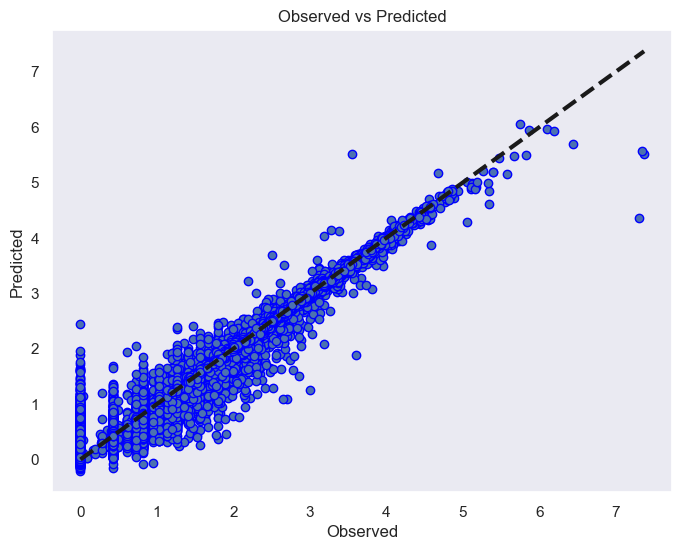

In [501]:
# So plot observed and predicted values of the test data for the best model i.e. tuned gradient boosting model
fig, ax = plt.subplots(figsize=(8, 6))
y_pred=gb_tuned.predict(X_test)
ax.scatter(y_test, y_pred, edgecolors=(0, 0, 1))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
ax.set_xlabel('Observed')
ax.set_ylabel('Predicted')
ax.set_title("Observed vs Predicted")
plt.grid()
plt.show()

- We can see that points are dense on the line where predicted is equal to the observed.
- This implies that most of the predicted values are close to the true values with some exceptions as seen in the plot. 

## Conclusions and Business Recommendations

### Model Improvements:
- We can use this predictive model for sales forecasting. The predictive model has been refined, leading to a significant reduction in error rates. Enhanced algorithms and additional features have contributed to more reliable sales forecasts. Incorporated additional lag features and rolling statistics to capture trends and seasonality.
- Used techniques like RandomizedSearchCV to optimize model parameters for better performance

### Business Recommendations:
- Focus marketing efforts during peak sales months (April to August) to maximize revenue
- Optimize the number of coolers and doors per store to enhance sales, as these features significantly correlate with sales volume.
- Monitor and adjust sales strategies based on weather conditions, as temperature variations may affect sales.

### Conclusion:
This new model can be significantly improved by refining features and tuning parameters. Implementing these changes will lead to more accurate sales forecasts, aiding in better inventory management and strategic planning.